# Modelagem e arquitetura CNN

## Modelo de canal único Optical Flow pré treinado VGG 16 + IMAGENET (Top layers off)

### Conteúdo

- Ingestão
- Pré processamento
- Modelagem da rede
- Treinamento
- Teste
- Validação
- Resultados

### Importações e parâmetros

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#import tensorflow_datasets as tfds
#tfds.disable_progress_bar()

videos_table_path = 'manual_of_classification.csv'
max_positive_cases = 5000
max_validation_cases = 10000
preprocess_training_test = True
preprocess_validation = False

### Ingestão

In [2]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def process_path(file_path):
    img = tf.io.read_file(file_path, )
    img = decode_img(img)
    return img

def process_label(label):
    return label == 'POS'

def process_dataframe(dataframe):
    xs = []
    ys = []
    with tf.device('/cpu:0'):
        for i,row in dataframe.iterrows():
            path = row['path']
            label = row['violence']
            xs.append(process_path(path))
            ys.append(process_label(label))
        return tf.data.Dataset.from_tensor_slices((xs,ys))

In [3]:
#IMPORT
frames_df = pd.read_csv(videos_table_path, sep=';', index_col=0)
video_list = frames_df[frames_df['load'] == 'X']['video'].unique()

#SEGREGATE
msk = np.random.rand(len(video_list)) < 0.9
train_test_videos = video_list[msk]
validation_videos =  video_list[~msk]
train_test_df = frames_df.loc[frames_df['video'].isin(train_test_videos)]
validation_df = frames_df.loc[frames_df['video'].isin(validation_videos)]
neg_df = train_test_df[train_test_df['violence'] == 'NEG'][['path','violence']]
pos_df = train_test_df[train_test_df['violence'] == 'POS'][['path','violence']]

#SHUFFLE
neg_df = neg_df.sample(frac=1).reset_index(drop=True)
pos_df = pos_df.sample(frac=1).reset_index(drop=True)
validation_df = validation_df.sample(frac=1).reset_index(drop=True)

#SAVE
validation_df.to_csv('validation_of_df.csv',sep=';')

#RESIZE
pos_df = pos_df.head(min([len(pos_df),max_positive_cases]))
neg_df = neg_df.head(len(pos_df))

#MERGE
merged_df = pd.concat([pos_df, neg_df], ignore_index=True)
dataset_length = len(merged_df)
validation_length = len(validation_df)

print('Train/test dataset cases :' + str(dataset_length))
print('Validation dataset cases :' + str(validation_length))

c:\users\red\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Train/test dataset cases :10000
Validation dataset cases :30914


In [4]:
validation_df = pd.read_csv('validation_of_df.csv',sep=';')

### Pré processamento

### Observações

Dataset claramente tendencioso (biased), será necessário tratar o desbalanceamento na fase de préprocessamento a fim de manter uma RN bem treinada.

#### Tarefas
- Separação do dataset em:
    - Dataset de treinamento (70%)
    - Dataset de teste (30%)

    
OBS: Todos os datasets devem estar balanceados! Portanto a medida balizadora será o gargalo atual: número de casos positivos. 

In [4]:
train_ds = None
test_ds = None
validation_ds = None

#RESHUFLE
if preprocess_training_test:
    shuffled_df = merged_df.sample(frac=1).reset_index(drop=True)
if preprocess_validation:
    validation_shuffled_df = validation_df.sample(frac=max_validation_cases/validation_length).reset_index(drop=True)

#PROCESS
if preprocess_training_test:
    complete_dataset = process_dataframe(shuffled_df)
if preprocess_validation:
    validation_ds = process_dataframe(validation_shuffled_df)

#SEPARATE
if preprocess_training_test:
    train_ds = complete_dataset.take(int(dataset_length*0.7))
    test_ds = complete_dataset.skip(int(dataset_length*0.7))

print('Train DataFrame size: ' + str(int(dataset_length*0.7)))
print('Test DataFrame size: ' + str(dataset_length - int(dataset_length*0.7)))
print('Validation DataFrame size: ' + str(int(validation_length)))

### Clear unused data
frames_df = None
neg_df = None
pos_df = None
#merged_df = None
shuffled_df = None
complete_dataset = None

Train DataFrame size: 7000
Test DataFrame size: 3000
Validation DataFrame size: 30914


In [5]:
train_batches = train_ds.shuffle(60).batch(32)

### Modelagem da CNN

In [6]:
# Create the base model from the pre-trained model VGG16
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
model = tf.keras.models.Sequential()
for layer in base_model.layers:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

flatten_layer = tf.keras.layers.Flatten()
dropout_layer = tf.keras.layers.Dropout(0.5)
dense_layer = tf.keras.layers.Dense(4096, activation='relu')
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

model.add(flatten_layer)
#model.add(dropout_layer)
model.add(tf.keras.layers.Dense(4096, activation='relu'))
#model.add(dropout_layer)
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(prediction_layer)

In [7]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]) #

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

### Salvar modelo

In [9]:
model.save('cnn_vgg16_pretrainned_dense_of_v2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_vgg16_pretrainned_dense_of_v2\assets


### Carregar modelo

- OBS : Lembrar de ligar GPU

In [10]:
model = tf.keras.models.load_model('cnn_vgg16_pretrainned_dense_of_v2')

### Treinamento

Utilizando o dataset de treino

In [ ]:
history = model.fit_generator(train_batches, epochs=100)#, callbacks=[ tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)])

Instructions for updating:
Please use Model.fit, which supports generators.
Train for 219 steps
Epoch 1/100
219/219 [==============================] - 47s 216ms/step - loss: 0.6937 - accuracy: 0.4984 - precision: 0.4062 - recall: 0.0037
Epoch 2/100
219/219 [==============================] - 43s 194ms/step - loss: 0.6931 - accuracy: 0.4993 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/100
219/219 [==============================] - 43s 194ms/step - loss: 0.6931 - accuracy: 0.4993 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/100
219/219 [==============================] - 42s 193ms/step - loss: 0.6931 - accuracy: 0.4993 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 5/100
219/219 [==============================] - 41s 189ms/step - loss: 0.6931 - accuracy: 0.4993 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/100
219/219 [==============================] - 41s 188ms/step - loss: 0.6931 - accuracy: 0.4993 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 7/100
219/21

### Salvar modelo

In [ ]:
model.save('cnn_vgg16_pretrainned_dense_of_v2')

### Avaliação do modelo

In [13]:
#test_batch = test_ds.batch(150)
#with tf.device('/cpu:0'):
features = np.array([list(x[0].numpy()) for x in list(test_ds)])
labels = np.array([x[1].numpy() for x in list(test_ds)])
test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=0)

print('\nTest accuracy:', test_acc)
print('\nTest precision:', test_prec)
print('\nTest recall:', test_rec)


Test accuracy: 0.777

Test precision: 0.83388704

Test recall: 0.6816022


Dataset de validação

In [6]:
features = np.array([list(x[0].numpy()) for x in list(validation_ds)])
labels = np.array([x[1].numpy() for x in list(validation_ds)])

In [7]:
test_loss, test_acc, test_prec, test_rec = model.evaluate(x=features, y=labels, verbose=0)

print('\nValidation accuracy:', test_acc)
print('\nValidation precision:', test_prec)
print('\nValidation recall:', test_rec)


Validation accuracy: 0.8703

Validation precision: 0.12673056

Validation recall: 0.19966443


In [8]:
print('\nValidation accuracy:', test_acc)
print('\nValidation precision:', test_prec)
print('\nValidation recall:', test_rec)


Validation accuracy: 0.8637

Validation precision: 0.23934427

Validation recall: 0.4016506


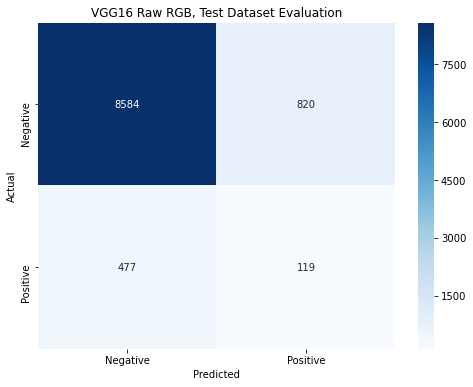

In [8]:
c_labels = [int(x) for x in labels]
predictions = model.predict_classes(features, batch_size=None)
pred = [x[0] for x in list(predictions)]
mat = tf.math.confusion_matrix(c_labels, pred)
df = pd.DataFrame(mat.numpy(), columns=['AP','AN'], index=['PP','PN'])
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(df, cmap="Blues", annot=True, fmt="d", xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
ax.set_ylim([2,0])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('VGG16 Raw RGB, Test Dataset Evaluation')
plt.show()

### Salvar modelo treinado

In [10]:
model.save('cnn_vgg16_pretrainned_dense_of')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: cnn_vgg16_pretrainned_dense_of\assets
